In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd
import gc

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


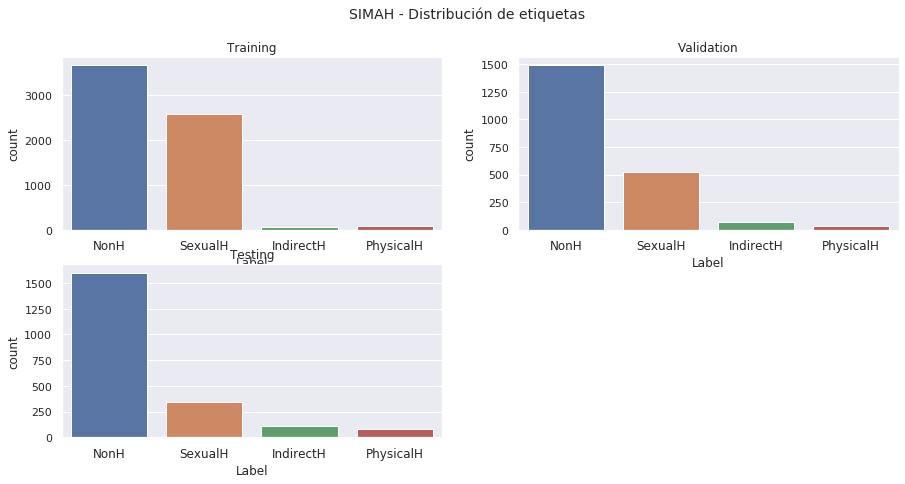

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=["NonH", "SexualH", "IndirectH", "PhysicalH"]
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("SIMAH - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)
    
    
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [5]:
MAX_LEN = 34
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [6]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [10]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [11]:
x_train.shape

(6374, 34, 200)

In [12]:
x_test.shape

(2123, 34, 200)

In [13]:
def load_data(mask, k, task):
    if task=='Stance':
        path='../Datasets/CSV_Stance'
    elif task=='Harassment':
        path='../Datasets/CSV_Harassment'
        
    macro_augmented = np.load(path+'/Aumento_ofi/balance_GloVe_'+mask+'_'+str(k)+'_run.npy', allow_pickle=True)
    np.random.shuffle(macro_augmented)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    print (np.unique(labels_train), type(labels_train))
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    n_labels = labels_train.copy()

    input_ids = []
    for sent in tws_train:
        encoded_sent = [] 
        for wd in sent:
            try:
                encoded_sent.append(token_2_idx[wd])
            except:
                continue
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], emb))
    j=0
    for in_id in input_ids:
        x_train[j]=EMB_matrix[in_id]
        j+=1

    return x_train, y_train, n_labels, class_weights


def train_5models(fold, e1, e2, x_val, y_val, xfrom, xto, task, balanced=False, x_train=None, y_train=None, n_labels=None, class_weights=None):
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    if balanced:
        mask=str(int(fold*100))
    
    if task== 'Stance':
        path='../Datasets/Models_Stance/'
    elif task== 'Harassment':
        path= '../Datasets/Models_Harassment/'
        
    for i in range(xfrom,xto + 1):    
        if balanced:
            x_train, y_train, n_labels, class_weights = load_data(mask, i, task)
        
        print ("\n\n -------------------- Entrenando exec", i," -------------------- \n\n")
        cnn1=create_cnn1(x_train.shape[1:])
        trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/cnn1_'+str(i)+'-exec.h5')   
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        cnn2=create_cnn2(x_train.shape[1:])
        trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/cnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/rnn1_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        trained.save(path+str(fold)+'/rnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/rnn3_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

    return fs_macro, fs_none, accs, confusions

## Original - No aumento

In [15]:
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
#class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)


Pesos de clases: [1.0, 1.0, 1.0, 1.0]


In [18]:
fs_macro, fs_none, accs, confusions= train_5models('0.0', 20, 10, x_val, y_val, 1, 20, 'Harassment', x_train=x_train, y_train=y_train, n_labels=n_labels, class_weights=class_weights)



 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.848
F1-score macro cnn1 : 0.409
F1-score None cnn1 : [0.912 0.    0.    0.725]

------ Testing ------
Accuracy cnn2 : 0.836
F1-score macro cnn2 : 0.392
F1-score None cnn2 : [0.904 0.    0.    0.665]

------ Testing ------
Accuracy rnn1 : 0.865
F1-score macro rnn1 : 0.430
F1-score None rnn1 : [0.923 0.    0.    0.796]

------ Testing ------
Accuracy rnn2 : 0.842
F1-score macro rnn2 : 0.448
F1-score None rnn2 : [0.916 0.    0.14  0.736]

------ Testing ------
Accuracy rnn3 : 0.861
F1-score macro rnn3 : 0.477
F1-score None rnn3 : [0.927 0.    0.155 0.826]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.853
F1-score macro cnn1 : 0.417
F1-score None cnn1 : [0.914 0.    0.    0.755]

------ Testing ------
Accuracy cnn2 : 0.849
F1-score macro cnn2 : 0.411
F1-score None cnn2 : [0.912 0.    0.    0.732]

------ Testing ------
Acc


------ Testing ------
Accuracy cnn2 : 0.850
F1-score macro cnn2 : 0.411
F1-score None cnn2 : [0.914 0.    0.    0.729]

------ Testing ------
Accuracy rnn1 : 0.868
F1-score macro rnn1 : 0.433
F1-score None rnn1 : [0.927 0.    0.    0.804]

------ Testing ------
Accuracy rnn2 : 0.847
F1-score macro rnn2 : 0.411
F1-score None rnn2 : [0.916 0.    0.    0.728]

------ Testing ------
Accuracy rnn3 : 0.812
F1-score macro rnn3 : 0.456
F1-score None rnn3 : [0.897 0.    0.188 0.738]


 -------------------- Entrenando exec 14  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.841
F1-score macro cnn1 : 0.400
F1-score None cnn1 : [0.907 0.    0.    0.691]

------ Testing ------
Accuracy cnn2 : 0.837
F1-score macro cnn2 : 0.395
F1-score None cnn2 : [0.905 0.    0.    0.675]

------ Testing ------
Accuracy rnn1 : 0.793
F1-score macro rnn1 : 0.384
F1-score None rnn1 : [0.889 0.    0.    0.647]

------ Testing ------
Accuracy rnn2 : 0.855
F1-score macro rnn2 : 0.427
F1-score None rnn2 

In [19]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0 - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0 - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0 - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.0 - F1-score promedio para cnn1 : [0.915 0.002 0.003 0.747]
0.0 - F1-score promedio para cnn2 : [0.917 0.    0.003 0.75 ]
0.0 - F1-score promedio para rnn1 : [0.887 0.    0.    0.71 ]
0.0 - F1-score promedio para rnn2 : [0.91  0.007 0.064 0.71 ]
0.0 - F1-score promedio para rnn3 : [0.911 0.    0.036 0.777]

0.0 - F1-score macro promedio para cnn1 : 0.4165294001645313 desvest:  0.00940797104878859
0.0 - F1-score macro promedio para cnn2 : 0.41724483217162434 desvest:  0.014623219779398813
0.0 - F1-score macro promedio para rnn1 : 0.39915130956468825 desvest:  0.050640301996771345
0.0 - F1-score macro promedio para rnn2 : 0.42291003603173916 desvest:  0.02496727545411376
0.0 - F1-score macro promedio para rnn3 : 0.4310939853369439 desvest:  0.03696818198133083

0.0 - Accuracy promedio para cnn1 : 0.8524258125294395 desvest:  0.007378976607308786
0.0 - Accuracy promedio para cnn2 : 0.8536033914272256 desvest:  0.010209113280560761
0.0 - Accuracy promedio para rnn1 : 0.8146726330664155 d

In [20]:
import matplotlib.pyplot as plt 

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

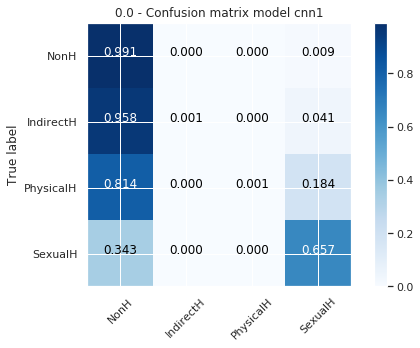

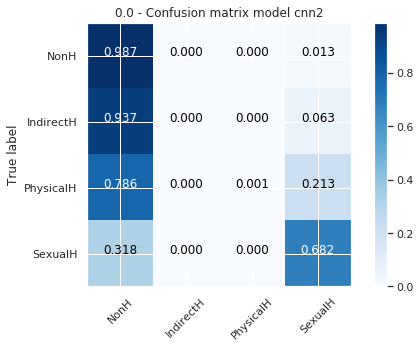

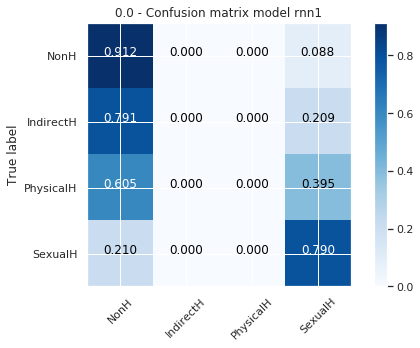

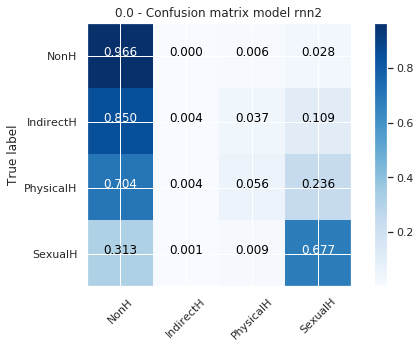

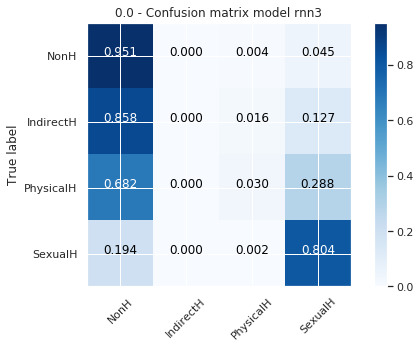

In [21]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='0.0 - Confusion matrix model '+str(key), cmap='Blues', normalize=True)

### Aumento CW

In [22]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights=np.asarray(class_weights)
## cw de lozano [0.157, 0.396, 0.399, 0.048].
print ("Pesos de clases:", class_weights)

Pesos de clases: [ 0.435 28.973 20.967  0.617]


In [23]:
fs_macro, fs_none, accs, confusions= train_5models('0.0cw', 20, 10, x_val, y_val, 1, 20, 'Harassment', x_train=x_train, y_train=y_train, n_labels=n_labels, class_weights=class_weights)



 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.837
F1-score macro cnn1 : 0.506
F1-score None cnn1 : [0.914 0.145 0.232 0.731]

------ Testing ------
Accuracy cnn2 : 0.838
F1-score macro cnn2 : 0.426
F1-score None cnn2 : [0.908 0.036 0.09  0.669]

------ Testing ------
Accuracy rnn1 : 0.369
F1-score macro rnn1 : 0.318
F1-score None rnn1 : [0.456 0.133 0.078 0.604]

------ Testing ------
Accuracy rnn2 : 0.849
F1-score macro rnn2 : 0.414
F1-score None rnn2 : [0.917 0.    0.    0.738]

------ Testing ------
Accuracy rnn3 : 0.687
F1-score macro rnn3 : 0.340
F1-score None rnn3 : [0.806 0.    0.026 0.527]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.837
F1-score macro cnn1 : 0.450
F1-score None cnn1 : [0.912 0.164 0.026 0.701]

------ Testing ------
Accuracy cnn2 : 0.812
F1-score macro cnn2 : 0.424
F1-score None cnn2 : [0.89  0.133 0.049 0.625]

------ Testing ------
Acc


------ Testing ------
Accuracy cnn2 : 0.838
F1-score macro cnn2 : 0.453
F1-score None cnn2 : [0.909 0.133 0.024 0.746]

------ Testing ------
Accuracy rnn1 : 0.765
F1-score macro rnn1 : 0.352
F1-score None rnn1 : [0.896 0.    0.259 0.251]

------ Testing ------
Accuracy rnn2 : 0.836
F1-score macro rnn2 : 0.436
F1-score None rnn2 : [0.911 0.    0.118 0.716]

------ Testing ------
Accuracy rnn3 : 0.257
F1-score macro rnn3 : 0.211
F1-score None rnn3 : [0.379 0.136 0.142 0.187]


 -------------------- Entrenando exec 14  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.806
F1-score macro cnn1 : 0.427
F1-score None cnn1 : [0.893 0.068 0.062 0.683]

------ Testing ------
Accuracy cnn2 : 0.864
F1-score macro cnn2 : 0.485
F1-score None cnn2 : [0.928 0.155 0.05  0.806]

------ Testing ------
Accuracy rnn1 : 0.620
F1-score macro rnn1 : 0.403
F1-score None rnn1 : [0.788 0.101 0.19  0.535]

------ Testing ------
Accuracy rnn2 : 0.841
F1-score macro rnn2 : 0.410
F1-score None rnn2 

In [24]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0cw - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0cw - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0cw - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.0cw - F1-score promedio para cnn1 : [0.91  0.103 0.091 0.72 ]
0.0cw - F1-score promedio para cnn2 : [0.906 0.121 0.112 0.693]
0.0cw - F1-score promedio para rnn1 : [0.747 0.148 0.197 0.307]
0.0cw - F1-score promedio para rnn2 : [0.91  0.002 0.045 0.72 ]
0.0cw - F1-score promedio para rnn3 : [0.727 0.145 0.192 0.525]

0.0cw - F1-score macro promedio para cnn1 : 0.455745439780366 desvest:  0.021495512814614422
0.0cw - F1-score macro promedio para cnn2 : 0.45792987091687276 desvest:  0.028188594829074796
0.0cw - F1-score macro promedio para rnn1 : 0.3499485577311787 desvest:  0.08633239039009637
0.0cw - F1-score macro promedio para rnn2 : 0.4191824043849316 desvest:  0.019091602270864694
0.0cw - F1-score macro promedio para rnn3 : 0.39750128718686517 desvest:  0.0789265973982027

0.0cw - Accuracy promedio para cnn1 : 0.8373056994818653 desvest:  0.017250562236588607
0.0cw - Accuracy promedio para cnn2 : 0.8309703250117758 desvest:  0.01581030251148224
0.0cw - Accuracy promedio para rnn1

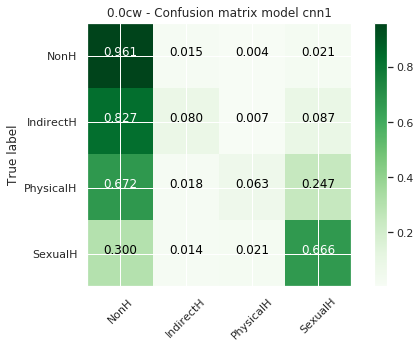

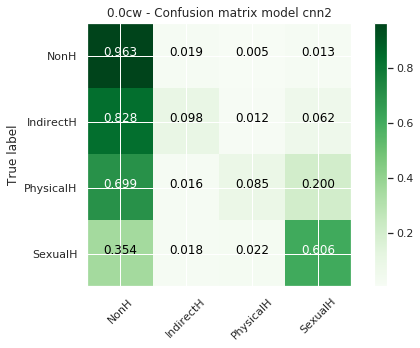

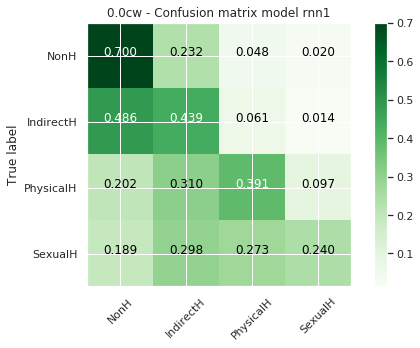

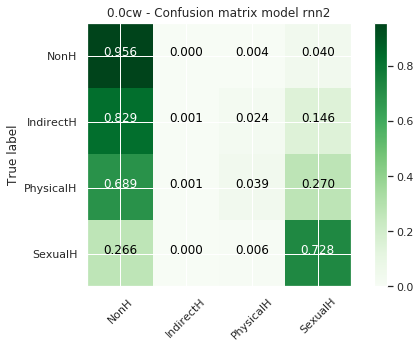

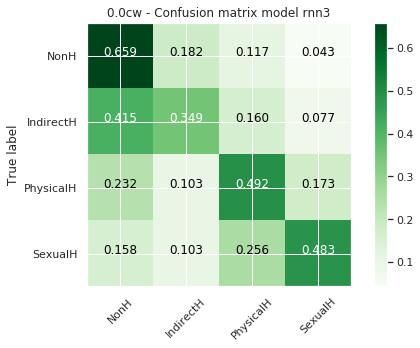

In [26]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='0.0cw - Confusion matrix model '+str(key), cmap='Greens', normalize=True)

## 15% Del 1 - 20

In [27]:
fs_macro, fs_none, accs, confusions= train_5models(0.15, 7, 4, x_val, y_val, 1, 20, 'Harassment', balanced=True)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.813
F1-score macro cnn1 : 0.381
F1-score None cnn1 : [0.892 0.05  0.026 0.557]

------ Testing ------
Accuracy cnn2 : 0.856
F1-score macro cnn2 : 0.429
F1-score None cnn2 : [0.919 0.036 0.    0.76 ]

------ Testing ------
Accuracy rnn1 : 0.686
F1-score macro rnn1 : 0.469
F1-score None rnn1 : [0.826 0.248 0.21  0.593]

------ Testing ------
Accuracy rnn2 : 0.853
F1-score macro rnn2 : 0.504
F1-score None rnn2 : [0.918 0.137 0.142 0.817]

------ Testing ------
Accuracy rnn3 : 0.608
F1-score macro rnn3 : 0.477
F1-score None rnn3 : [0.73  0.192 0.299 0.688]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.844
F1-score macro cnn1 : 0.421
F1-score None cnn1 : [0.916 0.    0.026 0.743]

------ Testing 


------ Testing ------
Accuracy cnn2 : 0.854
F1-score macro cnn2 : 0.442
F1-score None cnn2 : [0.915 0.017 0.049 0.787]

------ Testing ------
Accuracy rnn1 : 0.764
F1-score macro rnn1 : 0.534
F1-score None rnn1 : [0.867 0.264 0.27  0.737]

------ Testing ------
Accuracy rnn2 : 0.766
F1-score macro rnn2 : 0.484
F1-score None rnn2 : [0.859 0.23  0.145 0.701]

------ Testing ------
Accuracy rnn3 : 0.489
F1-score macro rnn3 : 0.385
F1-score None rnn3 : [0.586 0.181 0.225 0.547]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 13  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.841
F1-score macro cnn1 : 0.424
F1-score None cnn1 : [0.912 0.037 0.    0.748]

------ Testing ------
Accuracy cnn2 : 0.850
F1-score macro cnn2 : 0.416
F1-score None cnn2 : [0.915 0.018 0.    0.729]

------ Testing ------
Accuracy rnn1 : 0.705
F1-score macro rnn1 : 0.455
F1-score None rnn1 : [0.846 0.22  0.228 0.526]

------ Testing ------
Accu

In [28]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.15 - F1-score promedio para cnn1 : [0.916 0.028 0.028 0.745]
0.15 - F1-score promedio para cnn2 : [0.917 0.019 0.036 0.753]
0.15 - F1-score promedio para rnn1 : [0.878 0.21  0.252 0.662]
0.15 - F1-score promedio para rnn2 : [0.899 0.186 0.178 0.771]
0.15 - F1-score promedio para rnn3 : [0.831 0.213 0.247 0.672]

0.15 - F1-score macro promedio para cnn1 : 0.4290660888980796 desvest:  0.015350989343725157
0.15 - F1-score macro promedio para cnn2 : 0.4310244945634101 desvest:  0.012117234322025328
0.15 - F1-score macro promedio para rnn1 : 0.5003859526401923 desvest:  0.03238626538429975
0.15 - F1-score macro promedio para rnn2 : 0.508636313619529 desvest:  0.015772121017441635
0.15 - F1-score macro promedio para rnn3 : 0.4907807647904533 desvest:  0.04060643776190609

0.15 - Accuracy promedio para cnn1 : 0.8497880357983985 desvest:  0.010025229266134427
0.15 - Accuracy promedio para cnn2 : 0.8521196420160152 desvest:  0.0065530546352894235
0.15 - Accuracy promedio para rnn1 : 0.7818888

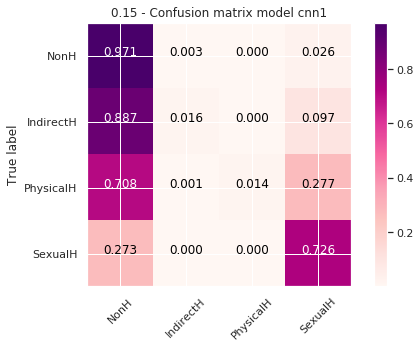

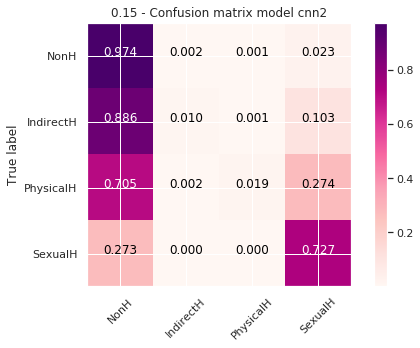

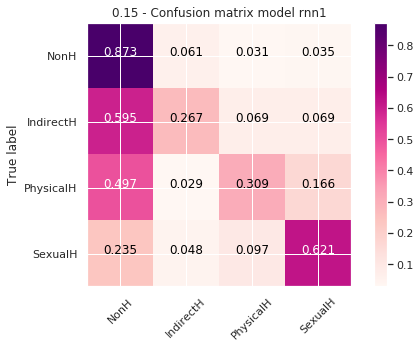

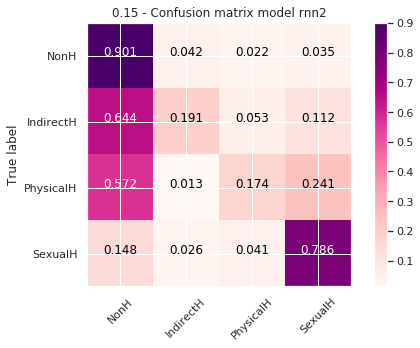

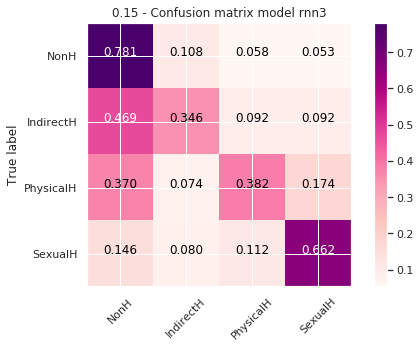

In [29]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='0.15 - Confusion matrix model '+str(key), cmap='RdPu', normalize=True)

## 50% De 1 - 20

In [30]:
fs_macro, fs_none, accs, confusions= train_5models(0.5, 7, 4, x_val, y_val, 1, 20, 'Harassment', balanced=True)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.829
F1-score macro cnn1 : 0.452
F1-score None cnn1 : [0.902 0.096 0.073 0.735]

------ Testing ------
Accuracy cnn2 : 0.842
F1-score macro cnn2 : 0.441
F1-score None cnn2 : [0.911 0.018 0.093 0.741]

------ Testing ------
Accuracy rnn1 : 0.656
F1-score macro rnn1 : 0.410
F1-score None rnn1 : [0.804 0.048 0.169 0.62 ]

------ Testing ------
Accuracy rnn2 : 0.804
F1-score macro rnn2 : 0.520
F1-score None rnn2 : [0.887 0.243 0.168 0.781]

------ Testing ------
Accuracy rnn3 : 0.717
F1-score macro rnn3 : 0.494
F1-score None rnn3 : [0.823 0.263 0.221 0.671]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.842
F1-score macro cnn1 : 0.434
F1-score None cnn1 : [0.914 0.    0.088 0.735]

------ Testing 


------ Testing ------
Accuracy cnn2 : 0.845
F1-score macro cnn2 : 0.432
F1-score None cnn2 : [0.916 0.    0.067 0.745]

------ Testing ------
Accuracy rnn1 : 0.677
F1-score macro rnn1 : 0.474
F1-score None rnn1 : [0.804 0.214 0.212 0.664]

------ Testing ------
Accuracy rnn2 : 0.780
F1-score macro rnn2 : 0.522
F1-score None rnn2 : [0.876 0.235 0.254 0.722]

------ Testing ------
Accuracy rnn3 : 0.782
F1-score macro rnn3 : 0.510
F1-score None rnn3 : [0.874 0.204 0.212 0.748]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 13  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.849
F1-score macro cnn1 : 0.431
F1-score None cnn1 : [0.914 0.018 0.025 0.767]

------ Testing ------
Accuracy cnn2 : 0.837
F1-score macro cnn2 : 0.456
F1-score None cnn2 : [0.906 0.079 0.133 0.704]

------ Testing ------
Accuracy rnn1 : 0.582
F1-score macro rnn1 : 0.441
F1-score None rnn1 : [0.724 0.187 0.254 0.599]

------ Testing ------
Accu

In [31]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.5 - F1-score promedio para cnn1 : [0.907 0.052 0.085 0.729]
0.5 - F1-score promedio para cnn2 : [0.908 0.05  0.063 0.729]
0.5 - F1-score promedio para rnn1 : [0.851 0.181 0.203 0.653]
0.5 - F1-score promedio para rnn2 : [0.89  0.167 0.187 0.73 ]
0.5 - F1-score promedio para rnn3 : [0.847 0.204 0.22  0.654]

0.5 - F1-score macro promedio para cnn1 : 0.443293674262012 desvest:  0.023014274458808465
0.5 - F1-score macro promedio para cnn2 : 0.4373462051975056 desvest:  0.018567079996805305
0.5 - F1-score macro promedio para rnn1 : 0.4718401632925652 desvest:  0.037356501000334545
0.5 - F1-score macro promedio para rnn2 : 0.49369579508130446 desvest:  0.022767342212850497
0.5 - F1-score macro promedio para rnn3 : 0.4810738014647054 desvest:  0.03193635527647261

0.5 - Accuracy promedio para cnn1 : 0.835044747998116 desvest:  0.012279929158408535
0.5 - Accuracy promedio para cnn2 : 0.8366462552991049 desvest:  0.016083227564976578
0.5 - Accuracy promedio para rnn1 : 0.744300518134715 desv

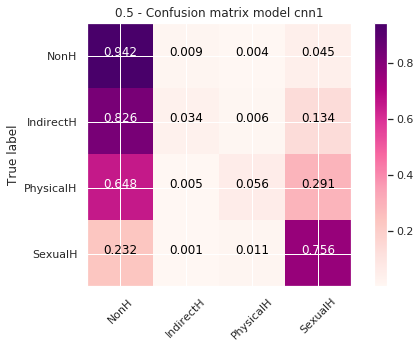

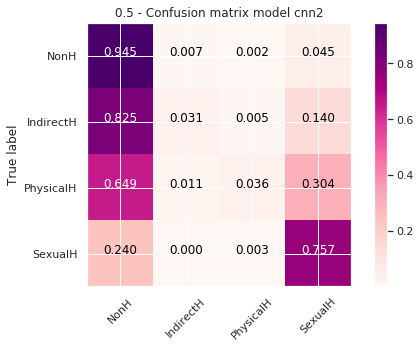

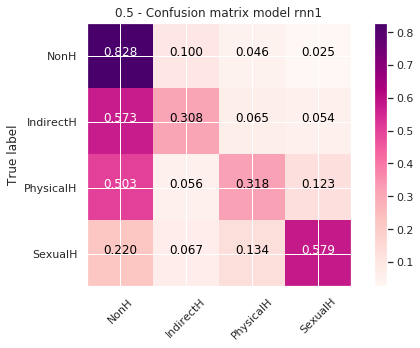

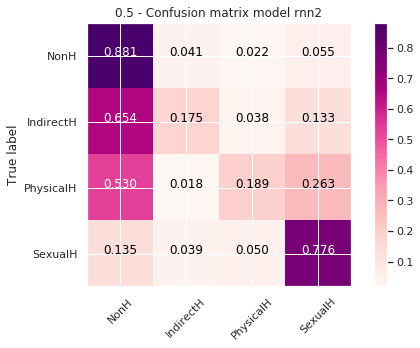

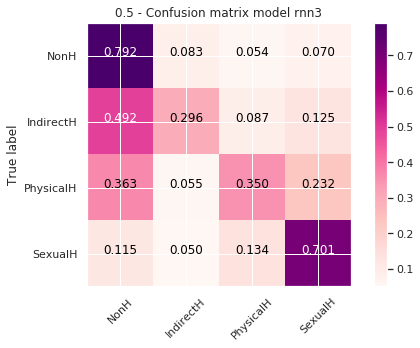

In [32]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='0.5 - Confusion matrix model '+str(key), cmap='RdPu', normalize=True)

## 85% De 1 - 10

In [33]:
fs_macro, fs_none, accs, confusions= train_5models(0.85, 7, 4, x_val, y_val, 1, 10, 'Harassment', balanced=True)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.843
F1-score macro cnn1 : 0.418
F1-score None cnn1 : [0.913 0.    0.025 0.735]

------ Testing ------
Accuracy cnn2 : 0.819
F1-score macro cnn2 : 0.427
F1-score None cnn2 : [0.897 0.071 0.025 0.716]

------ Testing ------
Accuracy rnn1 : 0.550
F1-score macro rnn1 : 0.387
F1-score None rnn1 : [0.724 0.167 0.218 0.438]

------ Testing ------
Accuracy rnn2 : 0.836
F1-score macro rnn2 : 0.469
F1-score None rnn2 : [0.908 0.074 0.139 0.755]

------ Testing ------
Accuracy rnn3 : 0.746
F1-score macro rnn3 : 0.495
F1-score None rnn3 : [0.849 0.213 0.196 0.723]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.807
F1-score macro cnn1 : 0.480
F1-score None cnn1 : [0.89  0.156 0.165 0.71 ]

------ Testing 

In [34]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.85 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.85 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.85 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.85 - F1-score promedio para cnn1 : [0.901 0.071 0.066 0.712]
0.85 - F1-score promedio para cnn2 : [0.896 0.071 0.05  0.714]
0.85 - F1-score promedio para rnn1 : [0.841 0.126 0.184 0.627]
0.85 - F1-score promedio para rnn2 : [0.872 0.147 0.181 0.719]
0.85 - F1-score promedio para rnn3 : [0.809 0.171 0.202 0.64 ]

0.85 - F1-score macro promedio para cnn1 : 0.43741926971054 desvest:  0.029077580382846174
0.85 - F1-score macro promedio para cnn2 : 0.4329336055049115 desvest:  0.018343360254165955
0.85 - F1-score macro promedio para rnn1 : 0.44444495363443187 desvest:  0.05109719860591446
0.85 - F1-score macro promedio para rnn2 : 0.4796587348299113 desvest:  0.024132931527137837
0.85 - F1-score macro promedio para rnn3 : 0.4553711782510644 desvest:  0.037160731073393564

0.85 - Accuracy promedio para cnn1 : 0.8256712199717381 desvest:  0.016381404971577983
0.85 - Accuracy promedio para cnn2 : 0.8185115402731983 desvest:  0.016666864500226503
0.85 - Accuracy promedio para rnn1 : 0.7335374

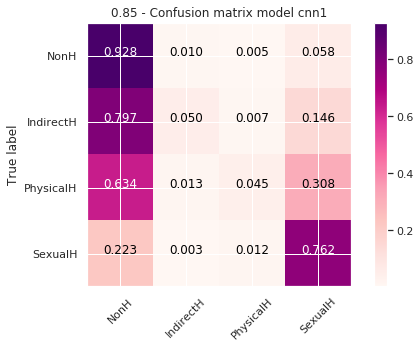

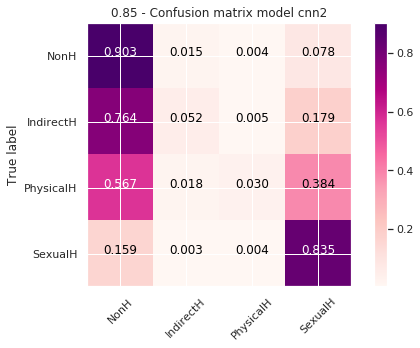

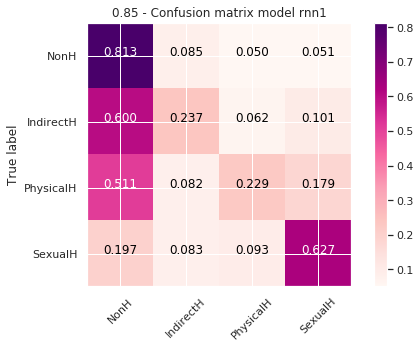

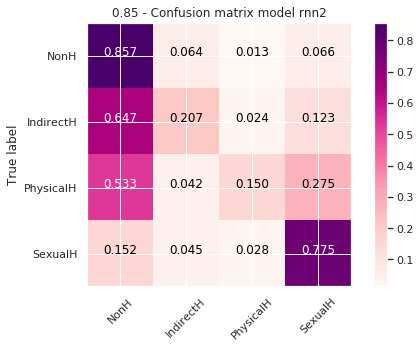

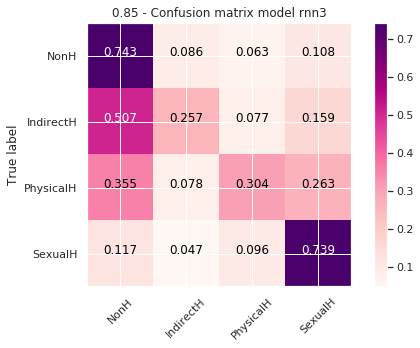

In [35]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/10.0), ["NonH", "IndirectH", "PhysicalH", "SexualH"], title='0.85 - Confusion matrix model '+str(key), cmap='RdPu', normalize=True)